In [4]:
# ## COVID testing and mortality data for the US states

# This notebook considers the relationship between COVID mortality and
# testing results for SARS-CoV-2 coronavirus exposure/infection, using
# data for the US obtained from the [COVID Tracking
# project](covidtracking.com).
#
# You can get the data by going to https://covidtracking.com/api, then
# downloading the CSV file under "historic state data".  Make sure to
# save the data using file name "ctp_daily.csv".  A direct link to the
# data is here:
#
# https://covidtracking.com/api/v1/states/daily.csv
#
# We will also use data about the population size for the US states.
# This can be obtained from various sources, we will get it directly
# from Wikipedia below.
#
# Our main interest here will be to assess whether the reported
# testing data for active viral infections are sufficient to explain
# the variation in COVID-related mortality.  People who die of COVID
# may do so 1-4 weeks after being infected (in most cases).
# Therefore, it is reasonable to anticipate that deaths will follow
# infections, with a time lag of this order.
#
# Testing in the US has been done quite haphazardly.  If we were
# testing a representative subset of the US population every day using
# an accurate test, it would be reasonable to anticipate a nearly 1-1
# relationship between positive test counts and mortality counts, at a
# lag as stated above.  In reality, testing intensity varies over time
# and between states.  The people getting tested are not at all
# representative of the total population, or even of the high-risk
# population.
#
# An additional factor is that not everyone who becomes infected with
# the coronavirus has the same chance of dying.  For example.  older
# people, males, and people in poor health are more likely to die.
# However we do not have data on either testing or mortality
# stratified by these factors.  This deficiency is expected to weaken
# the statistical relationship between test results and mortality in our
# data.
#
# The analysis below focuses on using Poisson and related forms of GLM
# regression to understand the relationship between coronavirus testing
# results and COVID mortality.  The analysis illustrates a number of
# aspects of generalized linear modeling that are important in many
# other settings.

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os


In [6]:
# Set this to False if you don't have gnuplot on your machine.  You
# can get gnuplot from www.gnuplot.info.

use_termplot = False

if use_termplot:
    import termplotlib as tpl

In [7]:
# Plot graphs here.

pdf = PdfPages("testing_mortality_usa.pdf")


In [8]:
# Below we get state population data from Wikipedia.  We only download
# the file one time and store it locally as 'states.csv'.

if not os.path.exists("states.csv"):

    # Map full state names to postal codes
    dm = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA",
        "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "District of Columbia": "DC",
        "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN",
        "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
        "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO",
        "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ",
        "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH",
        "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Puerto Rico": "PR", "Rhode Island": "RI",
        "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
        "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI",
        "Wyoming": "WY"}

    ta = pd.read_html("https://simple.m.wikipedia.org/wiki/List_of_U.S._states_by_population",
                      attrs={"class": "wikitable sortable"})
    ta = ta[0].iloc[:, 2:4]
    ta["SA"] = [dm.get(x, "") for x in ta.State]
    ta = ta.loc[ta.SA != "", :]
    ta.columns = ["state", "pop", "SA"]
    ta = ta.loc[:, ["state", "SA", "pop"]]
    ta = ta.sort_values(by="state")
    ta.to_csv("states.csv", index=None)

In [9]:
# Next we load and merge the COVID data and the state population data.

df = pd.read_csv("ctp_daily.csv")
dp = pd.read_csv("states.csv")
dp = dp.drop("state", axis=1)
df = pd.merge(df, dp, left_on="state", right_on="SA", how="left")
df["pdate"] = pd.to_datetime(df.date, format="%Y%m%d")
dx = df.loc[:, ["date", "pdate", "state", "positive", "negative", "death", "pop"]].dropna()
dx = dx.sort_values(by=["state", "pdate"])


In [10]:
# The data as provided are cumulative, so we difference it to get the
# daily values.

dx["ddeath"] = dx.groupby("state")["death"].diff()
dx["dpositive"] = dx.groupby("state")["positive"].diff()
dx["dnegative"] = dx.groupby("state")["negative"].diff()
dx = dx.dropna()

In [11]:
# A few values are negative when differenced, replace them with zero.
for x in "ddeath", "dpositive", "dnegative":
    print("Dropping %d cases where %s is negative" %
          ((dx[x] < 0).sum(), x))
    dx[x] = dx[x].clip(0, np.inf)
print("")

Dropping 39 cases where ddeath is negative
Dropping 17 cases where dpositive is negative
Dropping 47 cases where dnegative is negative



In [12]:
# ## Relationship between testing results and mortality
#
# The COVID Tracking project reports cumulative daily counts of
# COVID-related deaths for each US state, and also reports the
# cumulative numbers of positive and negative COVID tests.  The tests
# reported are primarily PCR tests that assess for viral RNA, which
# should indicate an active or recently cleared SARS-CoV-2 infection.
# The number of positive tests and the number of negative tests are
# reported for each US state and for each day.  Above we differenced
# the cumulative data to obtain per-day values for positive tests,
# negative tests, and deaths (mortality).

In [13]:
# Below we plot the daily death counts, and the daily counts of
# positive and negative tests for several states.

fmt = mdates.DateFormatter("%m-%d")
months = mdates.MonthLocator()

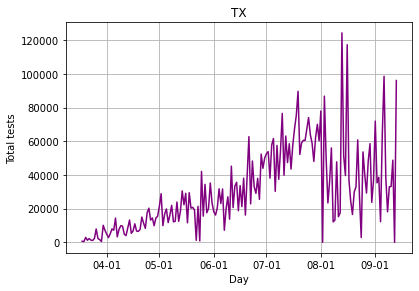

In [14]:
# Total tests per day in a state
dx["dtests"] = dx["dpositive"] + dx["dnegative"]

for st in "NY", "MI", "TX":
    for vn in "ddeath", "dpositive", "dtests":

        ti = {"ddeath": "Deaths", "dpositive": "Positive tests",
              "dtests": "Total tests"}[vn]

        da = dx.loc[dx.state==st, :]

        # Plot a crude graph in the terminal
        if use_termplot:
            fig = tpl.figure()
            x = (da.pdate - pd.to_datetime("2020-01-01")).dt.days
            fig.plot(x, da[vn].values, xlabel="Days since Jan 1, 2020",
                     title="%s/day in %s" % (ti, st))
            fig.show()
            print("")

        # Plot a nice graph and save it as a pdf
        plt.clf()
        plt.axes([0.15, 0.12, 0.8, 0.8])
        plt.grid(True)
        plt.plot(da.pdate.values.copy(), da[vn].values.copy(), '-', color='purple')
        plt.title(st)
        plt.xlabel("Day")
        plt.ylabel(ti)
        plt.gca().xaxis.set_major_formatter(fmt)
        plt.gca().xaxis.set_major_locator(months)
        pdf.savefig()


In [15]:
# Sum x from d2 days back in time to d1 days back in time, inclusive
# of both endpoints.  d2 must be greater than d1.

def wsum(x, d1, d2):
    w = np.ones(d2 + 1)
    if d1 > 0:
        w[-d1:] = 0
    y = np.zeros_like(x)
    y[d2:] = np.convolve(x.values, w[::-1], mode='valid')
    return y

for j in range(4):
    dx["cumpos%d" % j] = dx.groupby("state").dpositive.transform(lambda x: wsum(x, 7*j, 7*j+6))
    dx["cumneg%d" % j] = dx.groupby("state").dnegative.transform(lambda x: wsum(x, 7*j, 7*j+6))
    dx["logcumpos%d" % j] = np.log(dx["cumpos%d" % j] + 1)
    dx["logcumneg%d" % j] = np.log(dx["cumneg%d" % j] + 1)


In [16]:
# Below we will use regression analysis to try to understand how
# SARS-CoV-2 testing results relate to COVID mortality.  A reasonable
# hypothesis would be that a greater number of positive test results
# predicts greater mortality, at a 1-4 week lag.  More specifically,
# all else held equal, comparing two places/times where the COVID
# prevalence differs by a factor of two over the past month, we expect
# there to be a factor of two difference in COVID mortality today.
#
# Another plausible hypothesis (that turns out not to be supported by
# the data) is that the ratio of positive to negative test results,
# rather than the absolute number of positive test results, could be a
# stronger predictor of mortality.  This is based on the logic that
# taking this ratio corrects for the fact that states may increase
# their testing when a big surge in cases is expected.
#
# There are several other factors that we should consider and account
# for if possible:
#
# * The virus arrived in different states at different times, e.g. it
# arrived in New York before it arrived in South Dakota.
#
# * States vary greatly in terms of population size.  It is possible
# that death counts scale with population size (although early in an
# epidemic this may not hold).
#
# * Transmission rates may vary by state, e.g. due to population
# density.
#
# * The seasons were changing just as the epidemic in the US reached
# its peak.  Spring weather may reduce transmission rates.
#
# * The infection/fatality ratio (IFR) may vary by state due to
# demographic characteristics of the population and prevalence of
# comorbidities.


In [17]:
# To account for differences in the time when the disease arrived in
# each state, we identify the date of the first COVID death, then
# include only the data starting 10 days after that date.

def firstdeath(x):
    if (x.death == 0).all():
        return np.inf
    ii = np.flatnonzero(x.death > 0)[0]
    return x.pdate.iloc[ii]

xx = dx.groupby("state").apply(firstdeath)
xx.name = "firstdeath"
dx = pd.merge(dx, xx, left_on="state", right_index=True)


In [18]:
# Create a "relative date" variable, counting the days from the first
# COVID death in a state.

dx["rdate"] = (dx.pdate - dx.firstdeath).dt.days
dx = dx.loc[dx.rdate >= 10, :]

In [19]:
# Get the day of the week (Monday=0, Tuesday=1, etc.), which will be
# used as a covariate.  For administrative reasons, there are big
# differences in the reporting of deaths and test results by day.

dx["weekday"] = dx.pdate.dt.weekday

# Get the log population size (for each state).

dx["lpop"] = np.log(dx["pop"])

In [20]:
# Below is an initial regression analysis looking at mortality counts
# per state/day as an outcome, predicted by positive and negative
# testing results at multiple lags.  We also include state level fixed
# effects to control for the possibility of different ascertainment,
# different infection/fatality ratios, and other forms of
# heterogeneity among the states.  This initial model is fit using a
# quasi-Poisson generalized linear modeling (GLM) approach.  The model
# includes fixed effects for the states and for the days of the week.

fml = "ddeath ~ 0 + C(state) + C(weekday) + "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
fml += " + "
fml += " + ".join(["logcumneg%d" % j for j in range(4)])
m1 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r1 = m1.fit(scale="X2")
print(r1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 ddeath   No. Observations:                 8665
Model:                            GLM   Df Residuals:                     8599
Model Family:                 Poisson   Df Model:                           65
Link Function:                    log   Scale:                          12.799
Method:                          IRLS   Log-Likelihood:                -3748.1
Date:                Tue, 22 Sep 2020   Deviance:                       67136.
Time:                        20:20:11   Pearson chi2:                 1.10e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(state)[AK]       -1.4661      0.576     

In [21]:
# A perfect 1-1 relationship between testing and mortality would
# manifest as a perfect linear relationship between the log number of
# cases and the log number of positive tests.  However people who die
# of COVID expire at varying times relative to the date of their
# positive test. A very simple way to look at the scaling is that if
# all four lagging windows of positive tests increased by a given
# factor, then the number of deaths today would be expected to
# increase by this same factor.  This would imply that the
# coefficients for the positive test variables should sum to 1.
#
# The coefficients for the number of negative tests are informative in
# that they tell us whether we should consider the total amount of
# testing, or only the number of positive tests.  It is anticipated
# that the coefficients for negative tests would be negative, and if
# they are the additive inverses of the corresponding coefficients for
# positive tests, this would support using the proportion of positive
# tests, rather than the absolute number of positive tests, as a
# predictor of population exposure.


In [22]:
# An alternative approach to accommodating differences among the
# states is to use generalized estimating equations (GEE), clustering
# the data by states.  This accounts for correlations between the
# observations within a state without adding a large number of fixed
# effects parameters to the model.  We include here the log of each
# state's population to account for the state-to-state differences
# that are related to population size.

In [23]:
fml = "ddeath ~ C(weekday) + lpop + "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
fml += " + "
fml += " + ".join(["logcumneg%d" % j for j in range(4)])
m2 = sm.GEE.from_formula(fml, data=dx, groups="state", family=sm.families.Poisson())
r2 = m2.fit(scale="X2")
print(r2.summary())


                               GEE Regression Results                              
Dep. Variable:                      ddeath   No. Observations:                 8665
Model:                                 GEE   No. clusters:                       52
Method:                        Generalized   Min. cluster size:                 144
                      Estimating Equations   Max. cluster size:                 190
Family:                            Poisson   Mean cluster size:               166.6
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 22 Sep 2020   Scale:                          17.312
Covariance type:                    robust   Time:                         20:20:12
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -7.7547      1.312     -5.913      0.000     -10.325     

In [24]:
# ## State effects

# The analysis above uses state-level fixed effects to account for
# state-to-state differences from various sources.  From a statistical
# perspective, this is one of several ways to address this issue.
# Including large numbers of fixed effects in any regression model can
# raise concerns about there being sufficient data to estimate these
# parameters.  This is classically known as the "Neyman-Scott"
# problem.  Alternatives to fixed effects include mutilevel analysis,
# shrunken fixed effects, and marginal analysis that allow for
# covariances within states (which we have done here via GEE).


In [25]:
# Extract the state fixed effects
pa = r1.params
stfe = [[x[9:11], y] for x, y in zip(pa.index, pa.values) if "state" in x]
stfe = pd.DataFrame(stfe, columns=["state", "coef"])
stfe = stfe.sort_values(by="coef")
print("\nState fixed effects:\n")
print(stfe, "\n\n")



State fixed effects:

   state      coef
39    PR -5.480501
51    WY -2.076210
42    SD -1.539746
21    ME -1.487459
0     AK -1.466059
28    ND -1.380351
11    HI -1.197004
47    VT -1.132359
13    ID -1.057923
45    UT -1.051225
29    NE -1.027970
16    KS -0.994888
26    MT -0.769992
8     DE -0.653814
37    OR -0.322925
12    IA -0.308575
7     DC -0.303343
36    OK -0.303051
2     AR -0.286642
33    NV -0.181467
49    WI -0.149049
50    WV -0.143690
17    KY  0.010018
30    NH  0.029286
1     AL  0.030285
24    MO  0.045764
40    RI  0.191392
43    TN  0.209733
25    MS  0.210251
5     CO  0.278610
32    NM  0.322569
46    VA  0.325927
41    SC  0.371916
23    MN  0.417472
20    MD  0.474950
48    WA  0.499382
27    NC  0.545026
3     AZ  0.546228
15    IN  0.587878
10    GA  0.726714
18    LA  0.943035
35    OH  1.013106
6     CT  1.083088
9     FL  1.129663
14    IL  1.251060
44    TX  1.290221
38    PA  1.308863
31    NJ  1.373001
22    MI  1.427415
19    MA  1.508135
4     CA

In [54]:
# The state fixed effects discussed above are estimates, not exact
# values.  We can get a sense for how precise the estimates are by
# considering the standard errors. Note that these standard errors may
# be too small, as there is likely to be serial correlation in the
# counts that is not accounted for.  However taken at face-value, the
# standard errors suggest that the state fixed effects are estimated
# with reasonable accuracy.

ii = [i for i, x in enumerate(pa.index) if "state" in x]
c = r1.cov_params().iloc[ii, ii]
stfe["se"] = np.diag(c)

   state      coef        se
39    PR -5.480501  0.069751
51    WY -2.076210  0.033768
42    SD -1.539746  0.030037
21    ME -1.487459  0.036961
0     AK -1.466059  0.032008
28    ND -1.380351  0.038284
11    HI -1.197004  0.331826
47    VT -1.132359  0.039298
13    ID -1.057923  0.039374
45    UT -1.051225  0.108562
29    NE -1.027970  0.030418
16    KS -0.994888  0.032986
26    MT -0.769992  0.030922
8     DE -0.653814  0.031121
37    OR -0.322925  0.030615
12    IA -0.308575  0.039678
7     DC -0.303343  0.048602
36    OK -0.303051  0.118463
2     AR -0.286642  0.033295
33    NV -0.181467  0.027492
49    WI -0.149049  0.038965
50    WV -0.143690  0.032367
17    KY  0.010018  0.040539
30    NH  0.029286  0.031093
1     AL  0.030285  0.112737
24    MO  0.045764  0.032486
40    RI  0.191392  0.293595
43    TN  0.209733  0.033086
25    MS  0.210251  0.054134
5     CO  0.278610  0.033078
32    NM  0.322569  0.029812
46    VA  0.325927  0.029608
41    SC  0.371916  0.032522
23    MN  0.41

In [27]:
# Trimming off the tails, the state fixed effect coefficients range
# from roughly -1.5 to +1.5, a range of around 3.  Since exp(3) ~ 20,
# this suggests that there are pairs of states that would have around
# 20-fold different mortality even under the same amount of positive
# and negative test results.

In [28]:
# ## Alternative models and additional sources of confounding

# As with any observational data set, there are many opportunities for
# confounding to mislead us.  One such possibility is that all the US
# states have progressed through the COVID epidemic over roughly the
# same time period, and during this time the weather became much
# warmer in most of the US.  In fact, weather is just one possible
# confounder indexed by time (e.g. standards of care have evolved and
# may have impacted the IFR).  To address this possibility, we fit
# models in which calendar date, or date relative to the state's first
# COVID death are included as controls.  We find that the coefficients
# for the positive and negative testing results are relatively
# invariant to inclusion of these terms.

fml = "ddeath ~ 0 + C(state) + C(weekday) + bs(rdate, 5) + "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
fml += " + "
fml += " + ".join(["logcumneg%d" % j for j in range(4)])
m3 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r3 = m3.fit(scale="X2")
print(r3.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 ddeath   No. Observations:                 8665
Model:                            GLM   Df Residuals:                     8594
Model Family:                 Poisson   Df Model:                           70
Link Function:                    log   Scale:                          8.6636
Method:                          IRLS   Log-Likelihood:                -5343.2
Date:                Tue, 22 Sep 2020   Deviance:                       63777.
Time:                        20:20:13   Pearson chi2:                 7.45e+04
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(state)[AK]       -3.0611      0.495     

In [29]:
# Above we considered the relationship between infections and mortality
# to be static, i.e. the same relationship exists in all states at all
# times.  To explore the posibility that this relationship is dynamic,
# meaning that it is different in different places or at different
# times, we can include interactions in the model.

# Here we consider whether the relationship between infections and
# mortality differs between states with larger and smaller populations.
# Since population size is a state-level variable and we already have
# included state fixed effects in the model, a main effect of
# population size has already been accounted for in the models above.
# However we can take the question of population scaling a bit further
# by considering interactions between population size and the positive
# and negative test counts.

dx["lpop_cen"] = dx.lpop - dx.lpop.mean()
fml = "ddeath ~ 0 + C(state) + C(weekday) + bs(rdate, 5) + "
fml += " + ".join(["lpop_cen:logcumpos%d + logcumpos%d" % (j, j) for j in range(4)])
fml += " + "
fml += " + ".join(["lpop_cen:logcumneg%d + logcumneg%d" % (j, j) for j in range(4)])
m4 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r4 = m4.fit(scale="X2")

In [30]:
# It is also quite plausible that the relationship between infections
# and mortality has changed over the course of the pandemic.  We can
# consider this possibility by including interactions between the
# testing results and time (rdate).  We first do this by adding a
# "linear by linear" interactions between each positive testing
# variable and the number of days since the first death in a state
# (rdate).

fml = "ddeath ~ 0 + C(state) + C(weekday) + bs(rdate, 5) + "
fml += " + ".join(["logcumpos%d:rdate + logcumpos%d" % (j, j) for j in range(4)])
fml += " + "
fml += " + ".join(["logcumneg%d" % j for j in range(4)])
m5 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r5 = m5.fit(scale="X2")


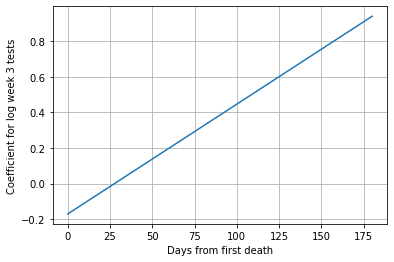

In [31]:
# Below is a plot of the "effective slope" relating mortality to
# logcumpos1 -- logcumpos3.

x = np.linspace(0, 180, 100)
for j in range(4):
    a = r5.params["logcumpos%d" % j]
    b = r5.params["logcumpos%d:rdate" % j]
    y = a + b*x

    if use_termplot:
        fig = tpl.figure()
        fig.plot(x, y, xlabel="Days from first death",
                 title="Coefficient for log week %d tests" % j)
        fig.show()
        print("")

    plt.clf()
    plt.grid(True)
    plt.plot(x.copy(), y.copy(), '-')
    plt.xlabel("Days from first death")
    plt.ylabel("Coefficient for log week %d tests" % j)
    pdf.savefig()


In [32]:
# Now we take this one step further, allowing the effective slope
# of mortality on infections to vary nonlinearly with time.

fml = "ddeath ~ 0 + C(state) + C(weekday) + bs(rdate, 5) + "
fml += " + ".join(["logcumpos%d*bs(rdate, 5)" % j for j in range(4)])
fml += " + "
fml += " + ".join(["logcumneg%d" % j for j in range(4)])
m6 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r6 = m6.fit(scale="X2")

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

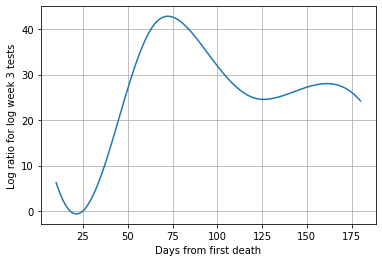

In [33]:
# Here is another plot of the "effective slopes" relating mortality to
# logcumpos1 -- logcumpos3, now using the model with nonlinear interactions.
# The key insight here is based on how positive tests at different lags
# predict deaths on a given day, and how these relationships change over
# time.

dxx = dx.iloc[0:200, :].copy()
x = np.linspace(10, 180, 100)
dxx["rdate"] = np.concatenate((x, x))
dxx["state"] = "MI"
dxx["weekday"] = 1
dxx[["logcumpos%d" % j for j in range(4)]] = np.log(10000)
dxx[["logcumneg%d" % j for j in range(4)]] = np.log(100000)
for j in range(4):

    dxx["logcumpos%d" % j].iloc[100:] = np.log(20000)

    y = r6.predict(exog=dxx)
    y = y.values.copy()

    if use_termplot:
        fig = tpl.figure()
        fig.plot(x, y[100:200] - y[0:100], xlabel="Days from first death",
                 title="Coefficient for log week %d tests" % j)
        fig.show()
        print("")

    plt.clf()
    plt.grid(True)
    plt.plot(x, y[100:200] - y[0:100], '-')
    plt.xlabel("Days from first death")
    plt.ylabel("Log ratio for log week %d tests" % j)
    pdf.savefig()

    dxx["logcumpos%d" % j].iloc[100:] = np.log(10000)


In [34]:
# We use quasi-AIC (QAIC) instead of AIC for quasi-poisson GLMs.
# Exclude the GEE model here.

m = [m1, m3, m4, m5, m6]
r = [r1, r3, r4, r5, r6]
c = r5.scale
for j in range(5):
    qaic = -2 * m[j].loglike(r[j].params, scale=1) / c + 2 * m[j].df_resid
    print("Model %d QAIC: %f" % (j+1, qaic))

Model 1 QAIC: 30371.166588
Model 2 QAIC: 29899.931509
Model 3 QAIC: 29688.621288
Model 4 QAIC: 28909.808090
Model 5 QAIC: 28618.611434


In [35]:
# ## Dispersion and the scale parameter

# Above we focused on the mean structure of the model, which is
# reflected in the slope parameters for the covariates.  These
# parameters determine the expected mortality count for any given
# state/date pair.  We should also consider to what extent the data
# are scattered with respect to this mean.  This is captured through
# the scale parameter of the quasi-Poisson regression.

print("\nScale parameter estimates:")
print(r1.scale)
print(r2.scale)
print(r3.scale)
print(r4.scale, "\n")


Scale parameter estimates:
12.798852502869567
17.312417344785118
8.663579190114334
8.21816943349513 



In [36]:
# In an ideal Poisson regression, the scale parameter is equal to 1,
# meaning that the conditional variance is equal to the conditional
# mean.
#
# The conventional approach for estimating the scale parameter is
# analogous to the sample variance, using the "Pearson residuals".

resid = r2.resid_pearson


In [37]:
# This is how the Pearson residuals are constructed:
f = np.exp(np.dot(m2.exog, r2.params))
resid0 = (m2.endog - f) / np.sqrt(f)

# Confirm that the residuals are calculated as expected
assert(np.all(np.abs(resid - resid0) < 1e-10))

# Confirm that the scale parameter estimate is calculated as expected
assert(np.abs(np.sum(resid**2) / (len(resid) - m2.exog.shape[1]) - r2.scale) < 1e-10)

In [38]:
# As we saw above, there are some large outliers in the mortality
# data, and we have good reason to believe that these outliers do not
# reflect actual daily death counts.  Therefore it might make sense to
# use an alternative approach to calculating the scale parameter that
# is not too strongly influenced by a few outlying values.  One way to
# do this is using "Huber's proposal 2" estimate of the scale.  This
# estimator solves a modified ("clipped") version of the moment-based
# estimating equation solved by the usual Pearson estimate of the
# scale parameter.

def g(s, resid):
    c = 1.345
    return np.sum(np.clip(resid / s, -c, c)**2)


In [39]:
# This is around 0.84, slightly less than 1 due
# to clipping.
gam = g(1, np.random.normal(size=50000)) / 50000


In [40]:
# Calculate robust estimates of the scale parameter for each of the
# models discussed above.

def huber_scale(resid, p):

    # This is the equation that we wish to solve to estimate
    # the scale parameter s.
    nobs = len(resid)
    def h(s):
        return g(s, resid).sum() - gam*(nobs - p)

    # Left bracket
    s0 = r.scale
    while h(s0) < 0:
        s0 /= 2

    # Right bracket
    s1 = r.scale
    while h(s1) > 0:
        s1 *= 2

    return root_scalar(h, bracket=[s0, s1]).root**2

from scipy.optimize import root_scalar
scale_huber = []
for (m, r) in (m1, r1), (m2, r2), (m3, r3), (m4, r4):
    s = huber_scale(r.resid_pearson, m1.exog.shape[1])
    scale_huber.append(s)

print("Robust scale parameter estimates:")
for s in scale_huber:
    print("%f" % s)
print("")

Robust scale parameter estimates:
4.437440
6.526226
4.154124
4.000478



In [41]:
# In a perfect Poisson situation, the variance would be equal to the
# mean.  This perfect Poisson behavior would arise if we had
# independence and homogeneity -- independence meaning that any two
# people living in the same state on the same day die of COVID
# independently of each other, and homogeneity meaning that any two
# people living in the same state on the same day have the same
# probability of dying of COVID.  Neither condition is likely to hold,
# but the homogeneity condition is particularly problematic.  Our data
# are not stratified by known risk factors, sex and age being most
# well-established.  Pooling data with different event probabilities
# will give us a scale parameter greater than 1, as is seen here.
#
# Although we don't have access to the stratified data that we would
# need to characterize these sources of dispersion, we can do some
# sensitivity analyses to see to what extent age and sex effects might
# inflate the scale parameter.


In [42]:
# The following function implements a form of sensitivity analysis in
# which we attempt to identify population structures that are
# consistent with the findings we reached above with the COVID
# tracking project data.  Our goal here is to get a better sense for
# how much heterogeneity would be needed to attain a scale parameter
# around 10, while respecting the marginal mean structure estimated
# above.  We can do this, in a very hypothetical way, by imagining
# that our population consists of two groups with different risks.  If
# we specify the prevalences of these two groups, and the risk ratio
# between them, and force the marginal mean to agree with what we
# found above, we can calculate the scale parameter.
#
# This idea is implemented in the function below.  The parameter
# 'high_risk' is a hypothetical risk ratio between a high risk group
# and a low risk group.  The parameter 'pr_high' is the hypothetical
# proportion of the population in the high risk group.

def scale_2group(high_risk, pr_high):

    # Setting f=high_risk, fraction pr_high of the cases will have
    # mean equal to f*s*ex, where ex is the mean of the observed data.
    # Fraction 1 - pr_high of the cases will have mean equal to s*ex.
    # Thus, the ratio of the mean in the first group to the mean in
    # the second group is f=high_risk.  To match the marginal mean of
    # the data, we need to solve p*f*s + (1-p)*s = 1.

    # The first group has mean f[0]*ex, the second group has mean
    # f[1]*ex.
    f = np.r_[1, high_risk]

    # The first group has frequency pr[0], the second group has
    # frequency pr[1]
    pr = np.r_[1 - pr_high, pr_high]

    # Adjust f so that f[1]/f[0] = high_risk, and the marginal mean
    # matches the fitted mean from the data.
    f /= np.dot(f, pr)

    # Get the means for the two hypothetical groups.
    ex = r1.fittedvalues
    exq = [fx*ex for fx in f]

    # Get the marginal variance if we are sampling from the mixed
    # populations of the two groups.
    mcv = sum([p*b for (p, b) in zip(pr, exq)])
    vcm = sum([p*(b-ex)**2 for (p, b) in zip(pr, exq)])
    tv = mcv + vcm

    # Return the scale parameter that would be seen if working with
    # pooled data from these two subpopulations.

    return (tv / ex).mean()


In [43]:
# We can now calculate the hypothetical scale parameter for an
# imaginary population in which 50% of the population (i.e. males) is
# 4 times more likely to die than the other people (females), we get a
# scale parameter that is similar to the observed scale parameter.
# This suggests that the scale parameters that we are obtaining can be
# explained by the heterogeneity driven by established risk factors
# such as age and sex.

print("Scale parameter due to 4-fold greater risk in half of the population:")
print(scale_2group(4.0, 0.5), "\n")


Scale parameter due to 4-fold greater risk in half of the population:
8.697892671668072 



In [44]:
# Calculate the scale parameter by state.  Our goal here is to
# understand the variance structure of the data.  If the scale
# parameters differ strongly by state, we haven't adequately captured
# the variance structure.

ds = pd.DataFrame({"state": m1.data.frame.state, "exp": r1.fittedvalues,
                   "obs": m1.data.frame.ddeath})
ds["resid"] = (ds["obs"] - ds["exp"]) / np.sqrt(ds["exp"])
p = m1.exog.shape[1]
state_scale = []
for st, dt in ds.groupby("state"):
    s = np.sum(dt["resid"]**2) / (dt.shape[0] - p)
    hs = huber_scale(dt["resid"], p)
    state_scale.append([st, s, hs])
state_scale = pd.DataFrame(state_scale, columns=["state", "scale", "robust_scale"])
state_scale = state_scale.sort_values(by="robust_scale")


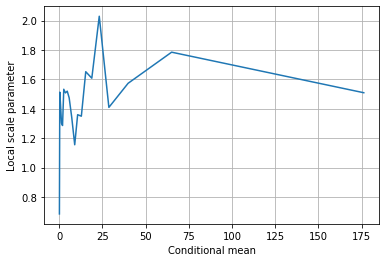

In [45]:
# Merge in the total number of deaths by state
td = dx.groupby("state").aggregate({"ddeath": np.sum})
state_scale = pd.merge(state_scale, td, left_on="state", right_index=True)
state_scale = state_scale.rename(columns={"ddeath": "total_deaths"})

## Assess the mean/variance relationship, attempt to find a
## relationship of the form Var(Y|X) = E[Y|X]^p

dr = pd.DataFrame({"fit": r1.fittedvalues, "resid": r1.resid_pearson})
dr["resid"] /= r1.fittedvalues**0.27  # Adjust this exponent to get a constant trend
dr["fitg"] = pd.qcut(dr["fit"], 20)
p = r1.model.exog.shape[1]
ds = dr.groupby("fitg").aggregate({"fitg": "first", "fit": np.mean,
                                   "resid": [np.var, lambda x: huber_scale(x, p/20)]})
ds.columns = [" ".join(x) for x in ds.columns]
ds = ds.rename(columns={"fitg first": "fit_range", "fit mean": "fit_mean",
                        "resid var": "scale", "resid <lambda_0>": "robust_scale"})

if use_termplot:
    fig = tpl.figure()
    fig.plot(ds.fit_mean, ds.robust_scale, xlabel="Conditional mean",
             title="Scale parameter")
    fig.show()

plt.clf()
plt.grid(True)
plt.plot(ds["fit_mean"].values.copy(), ds["robust_scale"].values.copy(), '-')
plt.xlabel("Conditional mean")
plt.ylabel("Local scale parameter")
pdf.savefig()


In [46]:
# Fit the model with the variance structure suggested by the above
# analysis

mp = sm.families.Poisson()
mp.variance = sm.families.varfuncs.Power(1.5)
fml = "ddeath ~ 0 + C(state) + C(weekday) + "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
fml += " + "
fml += " + ".join(["logcumneg%d" % j for j in range(4)])
m1z = sm.GLM.from_formula(fml, data=dx, family=mp)
r1z = m1z.fit(scale="X2")


In [47]:
# This is an equivalent model to what we have above, showing that the
# family parameter doesn't matter as long as the link and variance
# structures agree (at least for parameter estimation and standard
# errors).

m1t = sm.GLM.from_formula(fml, data=dx, family=sm.families.Tweedie(var_power=1.5))
r1t = m1t.fit(scale="X2")
assert(np.allclose(r1z.params, r1t.params))
assert(np.allclose(r1z.bse, r1t.bse)) # standard errors

In [48]:
# This is a sanity-check, to make sure that the results do change if we
# use different variance models.

m1x = sm.GLM.from_formula(fml, data=dx, family=sm.families.Tweedie(var_power=1.8))
r1x = m1x.fit(scale="X2")

assert(not np.allclose(r1x.params, r1t.params))
assert(not np.allclose(r1x.bse, r1t.bse)) # standard errors


In [49]:
# Refit the GLMs with heteroscedasticity-robust standard errors

r1x = m1.fit(cov_type="HC0")
r3x = m3.fit(cov_type="HC0")
r4x = m4.fit(cov_type="HC0")

In [50]:
pdf.close()